In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.random import normal, seed
from scipy.stats import norm
from numpy.random import choice
from pandas_datareader import data as pdr
import datetime
from statsmodels.graphics import tsaplots
from pylab import rcParams
import statsmodels.api as sm

Index(['Unnamed: 0', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')


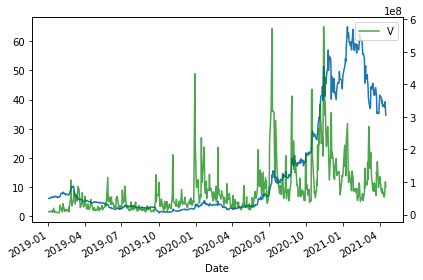

In [2]:

#print(current_date)
def generate_csv(symbol,filename):
    current_date=datetime.datetime.now()
    start_date=datetime.datetime(current_date.year-2,1,1)
    df = pdr.get_data_yahoo(symbol,start_date,current_date).reset_index()
    df.to_csv(filename)

generate_csv('GOOG','GOOG.csv')
generate_csv('NFLX','nflx.csv')
generate_csv('NIO','nio.csv')
generate_csv('DPZ','dpz.csv')
generate_csv('DIS','dis.csv')
generate_csv('AAPL','aapl.csv')
generate_csv('VMW','vmw.csv')
generate_csv('MSFT','MSFT.csv')
generate_csv('CSCO','CSCO.csv')
generate_csv('TSLA','TSLA.csv')
generate_csv('CGNX','CGNX.csv')
generate_csv('AMZN','AMZN.csv')
generate_csv('^GSPC','sp500.csv')

google=pd.read_csv('GOOG.csv',parse_dates=['Date'],index_col='Date')
netflix=pd.read_csv('nflx.csv',parse_dates=['Date'],index_col='Date')
nio=pd.read_csv('nio.csv',parse_dates=['Date'],index_col='Date')
dominos=pd.read_csv('dpz.csv',parse_dates=['Date'],index_col='Date')
disney=pd.read_csv('dis.csv',parse_dates=['Date'],index_col='Date')
apple=pd.read_csv('aapl.csv',parse_dates=['Date'],index_col='Date')
vmware=pd.read_csv('VMW.csv',parse_dates=['Date'],index_col='Date')
microsoft=pd.read_csv('MSFT.csv',parse_dates=['Date'],index_col='Date')
sp500=pd.read_csv('sp500.csv',parse_dates=['Date'],index_col='Date')
cisco=pd.read_csv('CSCO.csv',parse_dates=['Date'],index_col='Date')
tesla=pd.read_csv('TSLA.csv',parse_dates=['Date'],index_col='Date')
cgnx=pd.read_csv('CGNX.csv',parse_dates=['Date'],index_col='Date')
amazon=pd.read_csv('AMZN.csv',parse_dates=['Date'],index_col='Date')

sp500['Open']=sp500['Open'].resample('D').interpolate() #fix missing data

df=nio.copy()

#df['Date']=pd.to_datetime(df['Date'])
#df=df.set_index('Date')
df=df.sort_values(by='Date',ascending=True)
print(df.columns)
fig,ax=plt.subplots(figsize=(6,4))
df['Open'].plot(ax=ax)
twin_ax=ax.twinx()

df['Volume'].plot(ax=twin_ax, c='green', alpha=0.7)
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend('Volume')
plt.show()



In [3]:
print("""
Stock trading system evaluator: 1. 2 days of consecutive positive pct change opening price 
    2. hold on subsequent days of positive pct change opening price
    3. sell when opening price pct change is negative
""")
df['Shifted 1D']=df.Open.shift()
df['Shifted 2D']=df.Open.shift(periods=2)
df['Open_PCT']=df['Open'].pct_change()

df["Buy_Count"]=0

print("Look for stocks with buys and multiple days of positive pct change growth")

for index in range(len(df)):
    count=0
    for index2 in (range(index,0,-1)):
        if df.iloc[index2]["Open_PCT"]>0:
            count=count+1
        else:
            break
    df.iloc[index, df.columns.get_loc('Buy_Count')]=count
    
df['Action']=[ 'Sell' if x['Buy_Count']==0 else 'Buy' if x['Buy_Count']==2 else 'Hold' if x['Buy_Count'] > 2 else 'No Action' for key,x in df.iterrows()]

df["Target"]=0
for index in range(len(df)):
    action=df.iloc[index]["Action"]
    if (action=='Buy'):
             df.iloc[index, df.columns.get_loc('Target')]=1
    elif (action=='Sell'):
             df.iloc[index, df.columns.get_loc('Target')]=2

print(df[['Target','Action','Open_PCT','Open','Shifted 1D','Shifted 2D','Buy_Count']])




Stock trading system evaluator: 1. 2 days of consecutive positive pct change opening price 
    2. hold on subsequent days of positive pct change opening price
    3. sell when opening price pct change is negative

Look for stocks with buys and multiple days of positive pct change growth
            Target     Action  Open_PCT       Open  Shifted 1D  Shifted 2D  \
Date                                                                         
2019-01-02       2       Sell       NaN   6.130000         NaN         NaN   
2019-01-03       2       Sell -0.004894   6.100000    6.130000         NaN   
2019-01-04       0  No Action  0.014754   6.190000    6.100000    6.130000   
2019-01-07       1        Buy  0.035541   6.410000    6.190000    6.100000   
2019-01-08       0       Hold  0.024961   6.570000    6.410000    6.190000   
...            ...        ...       ...        ...         ...         ...   
2021-04-12       2       Sell -0.010169  37.959999   38.349998   37.619999   
2021-04-

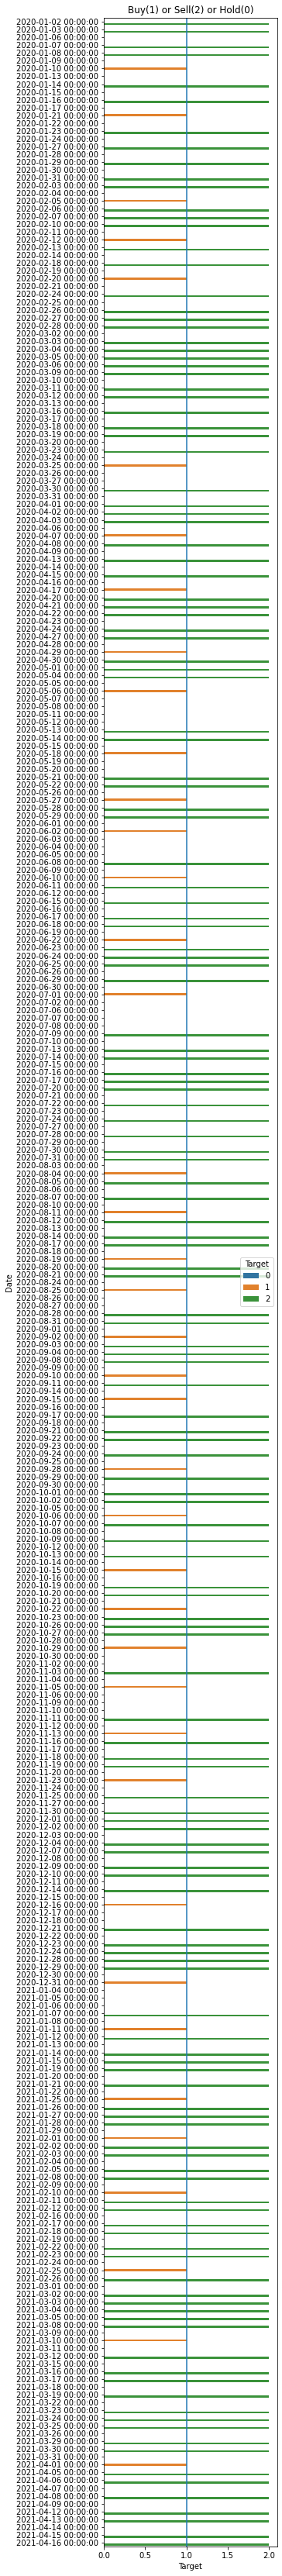

In [4]:
colors=[]
[colors.append('Red') if x=='2' else colors.append('Green') if x==1 else colors.append('White') for x in df['Target']]
plt.figure(figsize=(4,60))
#names.arg = colors
today = datetime.datetime.today()
filter=df.index.year >=  today.year-1
results=df[filter]

sns.barplot(data=results, x='Target', y=results.index, hue='Target')
plt.axvline(x=1, ymin=0, ymax=1)
plt.title('Buy(1) or Sell(2) or Hold(0)')
plt.show()

   Buy_Count  Incidence  Size
0          0          2   300
1          1          0   145
2          2          1    70
3          3          0    30
4          4          0    17
5          5          0    11
6          6          0     3
7          7          0     1
Number of Buys in the Data 30
Number of days holding Unnamed: 0    62
High          62
Low           62
Open          62
Close         62
Volume        62
Adj Close     62
Shifted 1D    62
Shifted 2D    62
Open_PCT      62
Buy_Count     62
Action        62
Target        62
dtype: int64
Incidence shows the average target value for each group


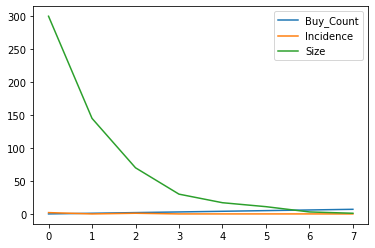

In [5]:
def create_pig_table(basetable, target, variable):
  
    # Create groups for each variable
    groups = basetable[[target,variable]].groupby(variable)
    
    pig_table=groups[target].agg([np.mean, np.size]).reset_index()
    pig_table=pig_table.rename(columns={'mean':'Incidence','size':'Size'})
    #pig_table = groups[target].agg({'Incidence' : np.mean, 'Size' : np.size}).reset_index()

    # Return the predictor insight graph table
    return pig_table

pig_table = create_pig_table(df, "Target", "Buy_Count")
print(pig_table)

print("Number of Buys in the Data", len(df[df['Buy_Count']==3]))

print("Number of days holding", df[(df["Action"]=='Hold')].count())

print("Incidence shows the average target value for each group")

pig_table.plot()
plt.show()

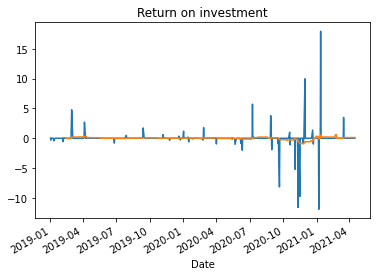

In [6]:
#df['Return']=df[df['Open']]
sellAmt=0
sellIndex=0
buyAmt=0
df['Return']=0
previousAction=""
for index in range(len(df)):
    count=0
    for index2 in (range(index,0,-1)):
        row=df.iloc[index2]
        #Print(row.Action, row.Open, row.Return)
        if row.Action=='Sell':
            if previousAction=='Sell':
                break
            sellAmt=row.Open
            sellIndex=index2
        if row.Action=='Buy' and (previousAction=='Hold' or previousAction=='Sell'):
            #print("Buy", sellIndex,index2)
            buyAmt=row.Open
            #print("Return",  previousAction, buyAmt,sellAmt,index2,sellIndex)
            df.iloc[sellIndex, df.columns.get_loc('Return')]=sellAmt-buyAmt
            break
        if row.Action=='No Action':
            break
        previousAction=row.Action
            
    #df.iloc[index, df.columns.get_loc('Buy_Count')]=count

#for key,item in df.iterrows():
#    print(item.Action,item.Open, "Return", item.Return)


df['Return_Avg'] = df['Return'].rolling(
    window=30,
    center=False
).mean()

df['Return'].plot()
df['Return_Avg'].plot()
plt.title('Return on investment')
plt.show()

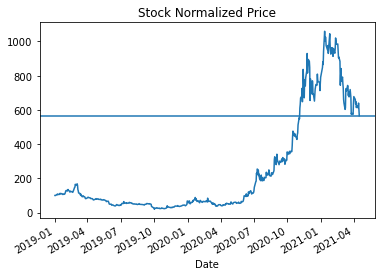

In [7]:
first_price=df['Open'].iloc[0]
last_price=df['Open'].iloc[len(df)-1]/first_price*100

normalized=df.Open.div(first_price).mul(100)
normalized.plot(title='Stock Normalized Price')
plt.axhline(y=last_price, xmin=0, xmax=1)
plt.show()


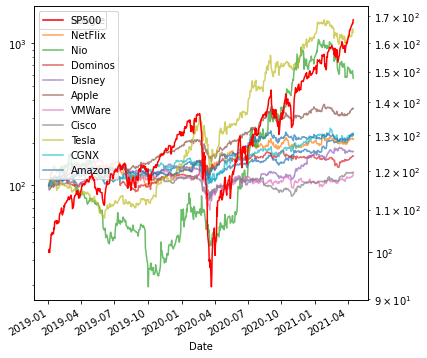

In [8]:
google['Normalized']=google['Open'].div(google['Open'].iloc[0]).mul(100)
microsoft['Normalized']=microsoft['Open'].div(microsoft['Open'].iloc[0]).mul(100)
tesla['Normalized']=tesla['Open'].div(tesla['Open'].iloc[0]).mul(100)
nio['Normalized']=nio['Open'].div(nio['Open'].iloc[0]).mul(100)
netflix['Normalized']=netflix['Open'].div(netflix['Open'].iloc[0]).mul(100)
dominos['Normalized']=dominos['Open'].div(dominos['Open'].iloc[0]).mul(100)
disney['Normalized']=disney['Open'].div(disney['Open'].iloc[0]).mul(100)
apple['Normalized']=apple['Open'].div(apple['Open'].iloc[0]).mul(100)
vmware['Normalized']=vmware['Open'].div(vmware['Open'].iloc[0]).mul(100)
sp500['Normalized']=sp500['Open'].div(sp500['Open'].iloc[0]).mul(100)
cisco['Normalized']=cisco['Open'].div(cisco['Open'].iloc[0]).mul(100)
cgnx['Normalized']=cgnx['Open'].div(cgnx['Open'].iloc[0]).mul(100)
amazon['Normalized']=amazon['Open'].div(amazon['Open'].iloc[0]).mul(100)


compare=google.merge(microsoft['Normalized'],on='Date',how='left').rename(columns={'Normalized_x':'Google','Normalized_y':'Microsoft'}).drop(columns=['Volume','High','Low','Close','Adj Close']).fillna(0)
compare=compare.merge(netflix['Normalized'],on='Date',how='left').rename(columns={'Normalized':'NetFlix'}).fillna(0)
compare=compare.merge(nio['Normalized'],on='Date',how='left').rename(columns={'Normalized':'Nio'}).fillna(0)
compare=compare.merge(tesla['Normalized'],on='Date',how='left').rename(columns={'Normalized':'Tesla'}).fillna(0)
compare=compare.merge(dominos['Normalized'],on='Date',how='left').rename(columns={'Normalized':'Dominos'}).fillna(0)
compare=compare.merge(disney['Normalized'],on='Date',how='left').rename(columns={'Normalized':'Disney'}).fillna(0)
compare=compare.merge(apple['Normalized'],on='Date',how='left').rename(columns={'Normalized':'Apple'}).fillna(0)
compare=compare.merge(vmware['Normalized'],on='Date',how='left').rename(columns={'Normalized':'VMWare'}).fillna(0)
compare=compare.merge(sp500['Normalized'],on='Date',how='left').rename(columns={'Normalized':'SP500'}).fillna(0)
compare=compare.merge(cisco['Normalized'],on='Date',how='left').rename(columns={'Normalized':'Cisco'}).fillna(0)
compare=compare.merge(cgnx['Normalized'],on='Date',how='left').rename(columns={'Normalized':'CGNX'}).fillna(0)
compare=compare.merge(amazon['Normalized'],on='Date',how='left').rename(columns={'Normalized':'Amazon'}).fillna(0)

#print(compare)



#compare=compare.div(compare.iloc[0]).mul(100)

tickers=['Google','NetFlix','Nio','Dominos','Disney','Apple','VMWare','Cisco','Tesla','CGNX','Amazon']
#tickers=['Nio','Tesla']
#print(compare)
fig,ax=plt.subplots(figsize=(6,6))
plt.yscale("log")
compare[tickers].plot(ax=ax,alpha=.7)
twin_ax=ax.twinx()
compare[['SP500']].plot(ax=twin_ax, c='red')
plt.yscale("log")
plt.show()


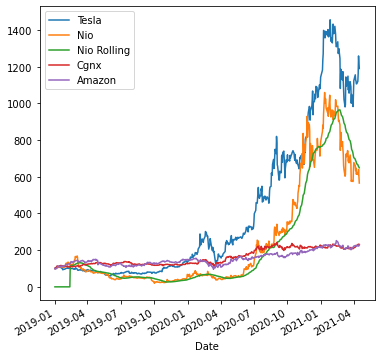

In [9]:
#print(compare)
nio_rolling_30=nio.rolling(window=30).mean()

fig,ax=plt.subplots(figsize=(6,6))
tesla['Normalized'].plot(ax=ax)
nio['Normalized'].plot(ax=ax)
nio_rolling_30['Normalized'].fillna(0).plot(ax=ax)
amazon['Normalized'].plot(ax=ax)
cgnx['Normalized'].plot(ax=ax)
plt.legend(['Tesla','Nio','Nio Rolling','Cgnx','Amazon'])
plt.show()


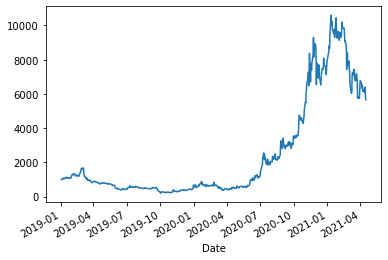

In [10]:
investment=1000
returns=nio['Open'].pct_change()

returns_plus_one = returns.add(1)
cumulative_return = returns_plus_one.cumprod()

# Calculate and plot the investment return here 
cumulative_return.mul(investment).plot()
plt.show()

Simulate the sp500


C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


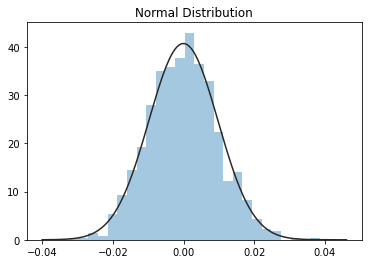

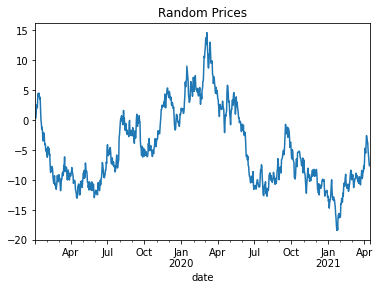

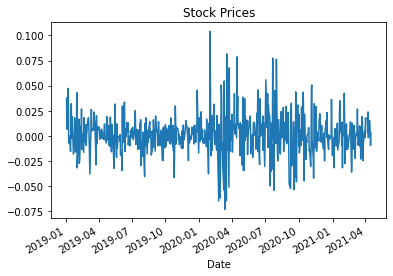

C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


The sp500 does the fit the normal distribution well having more outliers


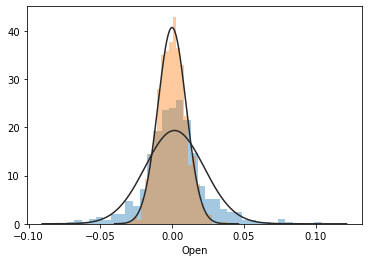

In [11]:
print("Simulate the sp500")

seed(42)

#obj=sp500
obj=amazon
dates=pd.date_range(start=obj.index.min(), end=obj.index.max(),freq='D')

random_returns= normal(loc=0, scale=.01, size=len(dates))
sns.distplot(random_returns, fit=norm, kde=False)
plt.title('Normal Distribution')
plt.show()

#print(len(dates),len(random_returns))
return_df=pd.DataFrame({'date':dates,'prices':random_returns})
return_df=return_df.set_index('date')
#print(return_df)

random_prices=return_df.prices.add(1).cumprod().sub(1)
random_prices.mul(100).plot()
plt.title('Random Prices')
plt.show()

returns_obj=obj['Open'].pct_change()
returns_obj.plot()
plt.title('Stock Prices')
plt.show()

sns.distplot(returns_obj, fit=norm, kde=False)
sns.distplot(random_returns, fit=norm, kde=False)
print("The sp500 does the fit the normal distribution well having more outliers")

randomly sample from data
Date
2019-01-02    2476.959961
2019-01-03       0.997554
2019-01-04       0.986628
2019-01-07       0.987981
2019-01-08       1.007573
dtype: float64


<AxesSubplot:xlabel='Date'>

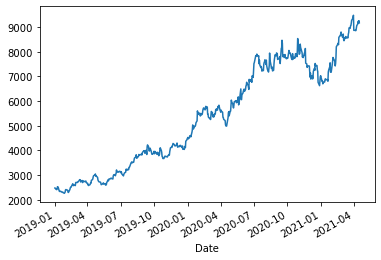

In [12]:
print ('randomly sample from data')
sample=returns_obj.dropna()
n_obs= returns_obj.count()
random_walk = choice(sample, size=n_obs)

random_walk = pd.Series(random_walk, index=sample.index)
#random_walk.head()

start = sp500['Open'].first('D')

sp500_random = start.append(random_walk.add(1))
print(sp500_random.head())

sp500_random= sp500_random.cumprod()
sp500_random.plot()

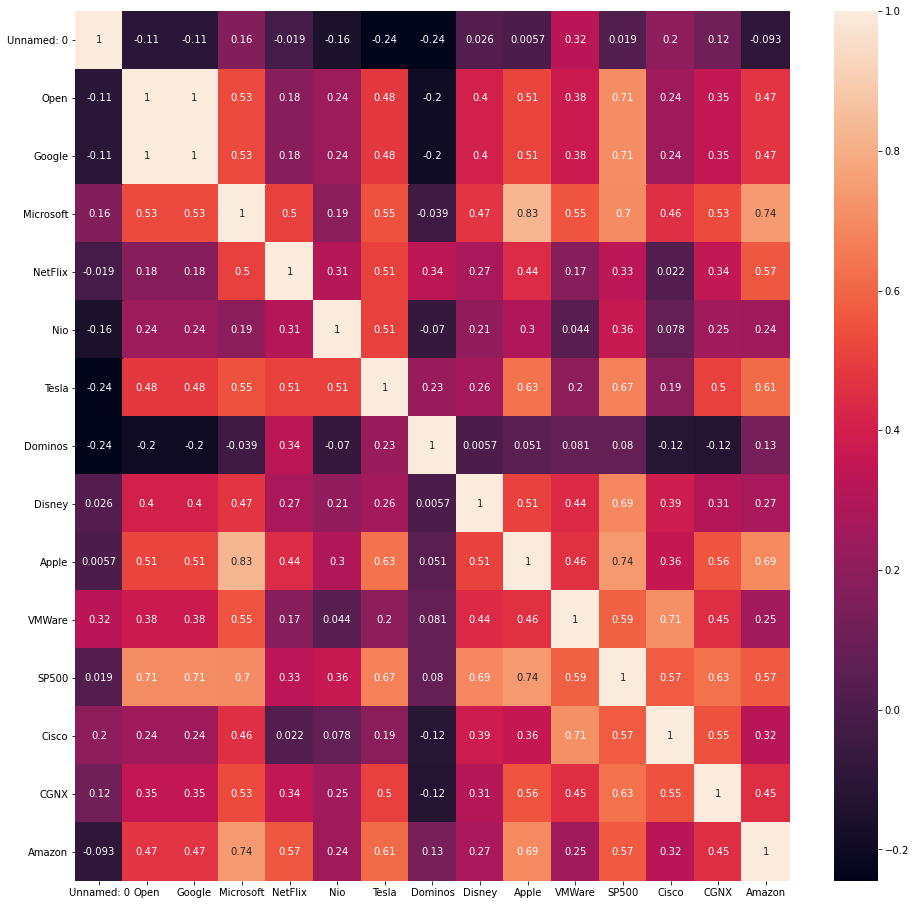

In [13]:
#print(compare)
growth=compare.resample('M').last()
growth_returns= growth.pct_change()

correlations=growth_returns.corr()
plt.figure(figsize=(16,16))
sns.heatmap(correlations,annot=True)
plt.show()

How much money was added to the comparision
compare capitalization 4570.716517583049
Determine the return by index
Index Return 197.31%


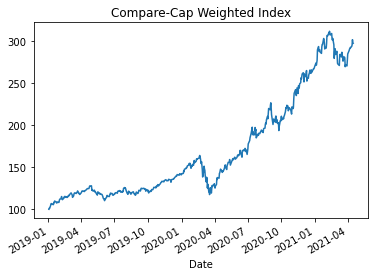

In [14]:
agg_compare_cap=compare.sum(axis=1)
index=agg_compare_cap.div(agg_compare_cap.iloc[0]).mul(100)
index.plot(title='Compare-Cap Weighted Index')

print('How much money was added to the comparision')
print("compare capitalization", agg_compare_cap.iloc[-1] - agg_compare_cap.iloc[0])

print('Determine the return by index')


index_return = (index.iloc[-1] / index.iloc[0] -1) * 100 
print("Index Return {0:.2f}%".format(index_return))



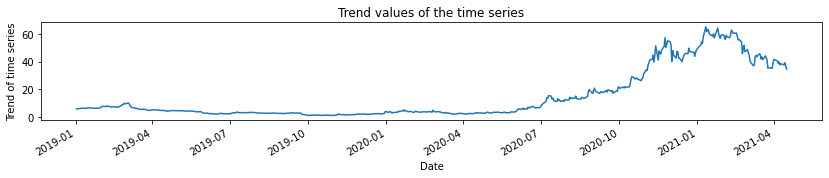

In [18]:
rcParams['figure.figsize']=11,9
decomposition=sm.tsa.seasonal_decompose(x=df['Open'],model='additive', extrapolate_trend='freq', period=1)
#decomposition.plot()
#plt.show()

decomposition_trend=decomposition.trend
ax= decomposition_trend.plot(figsize=(14,2))
ax.set_xlabel('Date')
ax.set_ylabel('Trend of time series')
ax.set_title('Trend values of the time series')
plt.show()